In [1]:
#Import knižníc
import torch
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import re
import matplotlib.pyplot as plt

/Users/annahavryliak/IdeaProjects/ZS2/pythonProject/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/annahavryliak/IdeaProjects/ZS2/pythonProject/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
#Nacitanie datasetu
df = pd.read_csv('data/245k_tweets.csv')

def clean_text(text):
    #Previesť text na malé písmená
    text = text.lower()
    
    #Odstránenie adries URL
    text = re.sub(r'http\S+', '', text)
    
    #Odstránenie hashtagov (iba symbol „#“, text ponechajte)
    text = re.sub(r'#', '', text)
    
    #Odstránenie špeciálnych znakov a čísel
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    
    #Odstránenie zbytočných medzier
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

#Zápis očistených údajov do nového stĺpca
df['clearcontent'] = df['tweet'].apply(clean_text)

In [4]:
#Definovanie hyperparametrov
MAX_LEN = 128
BATCH_SIZE = 16

In [5]:
#Stiahnutie tokenizéra RoBERT
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [6]:
#Vytvorenie triedy pre dátasety
class PredictionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        content = self.data.iloc[idx]['clearcontent']

        #Tokenizacia textu
        encoding = self.tokenizer.encode_plus(
            content,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'clearcontent': content,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [7]:
#Vytváranie datasetov a súborov loadov
prediction_dataset = PredictionDataset(df, tokenizer, MAX_LEN)
prediction_loader = DataLoader(prediction_dataset, batch_size=BATCH_SIZE)

In [8]:
#Definícia zariadenia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
#Načítanie základného modelu
roberta_model = RobertaModel.from_pretrained('roberta-base')

In [10]:
#Stiahnutie modelu
class RobertaClassifier(torch.nn.Module):
    def __init__(self, roberta_model, dropout=0.3):
        super(RobertaClassifier, self).__init__()
        self.roberta = roberta_model
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]
        dropout_output = self.dropout(pooled_output)
        linear_output = self.classifier(dropout_output)
        return linear_output

In [11]:
#Načítanie natrénovaných váh
model = RobertaClassifier(roberta_model)
model.load_state_dict(torch.load('robert_model.pth'))
model = model.to(device)

In [12]:
#Funkcia pre predikcie
def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())

    return predictions

In [13]:
#Získavanie predikcie
predictions = predict(model, prediction_loader, device)

In [14]:
#Pridanie predikcie do datasetu
df['prediction'] = predictions

In [15]:
#Nahradenie číselných hodnôt zrozumiteľnými popismi
label_mapping = {0: 'fake', 1: 'real'}
df['prediction'] = df['prediction'].map(label_mapping)

In [17]:
#Uloženie výsledkov do nového súboru CSV
df.to_csv('data/robert_results.csv', index=False)

In [18]:
#Nacitanie datasetu
df_pred = pd.read_csv('data/robert_results.csv')

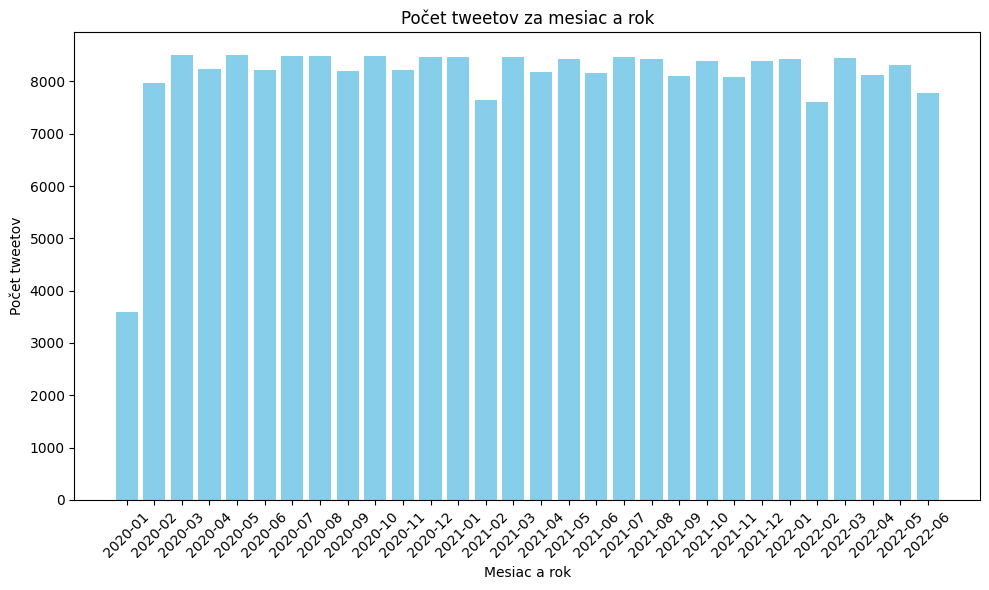

In [19]:
#Zoskupenie údajov podľa 'month_year' a spočítanie počtu tweetov
tweet_count = df_pred.groupby('month_year').size().reset_index(name='count')

#Vizualizacia počtu tweetov za kazdy mesiac
plt.figure(figsize=(10, 6))
plt.bar(tweet_count['month_year'], tweet_count['count'], color='skyblue')
plt.title('Počet tweetov za mesiac a rok')
plt.xlabel('Mesiac a rok')
plt.ylabel('Počet tweetov')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
df_pred = df_pred[df_pred['month_year'] != '2020-01']

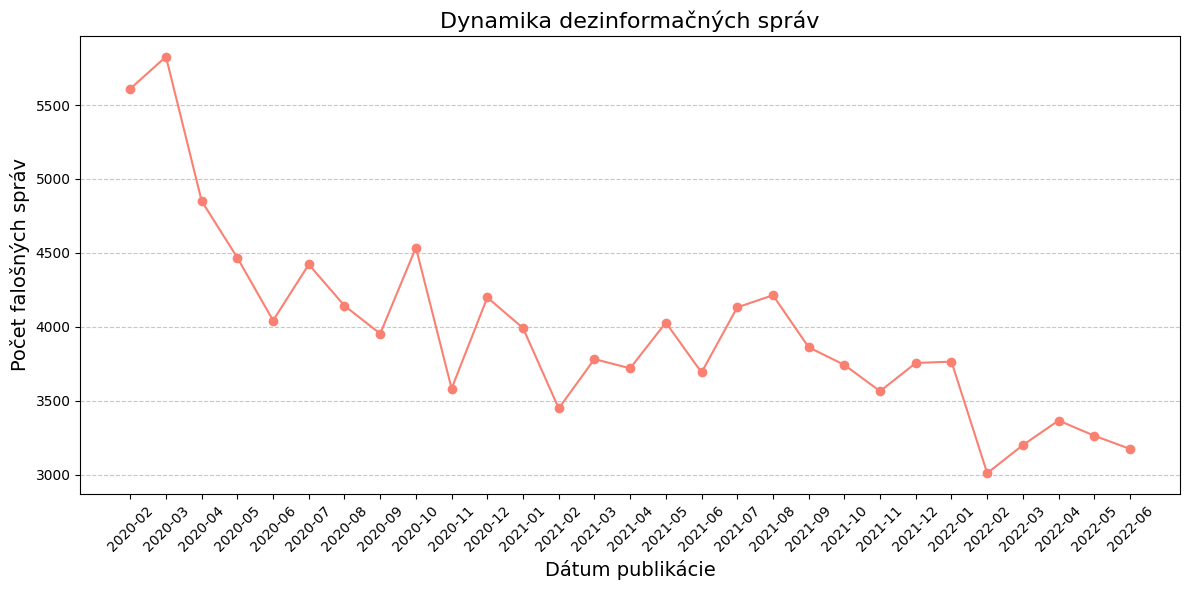

In [21]:
#Filtrovanie iba falošných postov
fake_posts = df_pred[df_pred['prediction'] == 'fake']

#Zoskupenie podľa month_year a počítanie počtu falošných postov
fake_counts = fake_posts.groupby('month_year').size().reset_index(name='count')

#Vizualizacia
plt.figure(figsize=(12, 6))
plt.plot(fake_counts['month_year'], fake_counts['count'], marker='o', color='salmon', linestyle='-')

plt.title('Dynamika dezinformačných správ', fontsize=16)
plt.xlabel('Dátum publikácie', fontsize=14)
plt.ylabel('Počet falošných správ', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

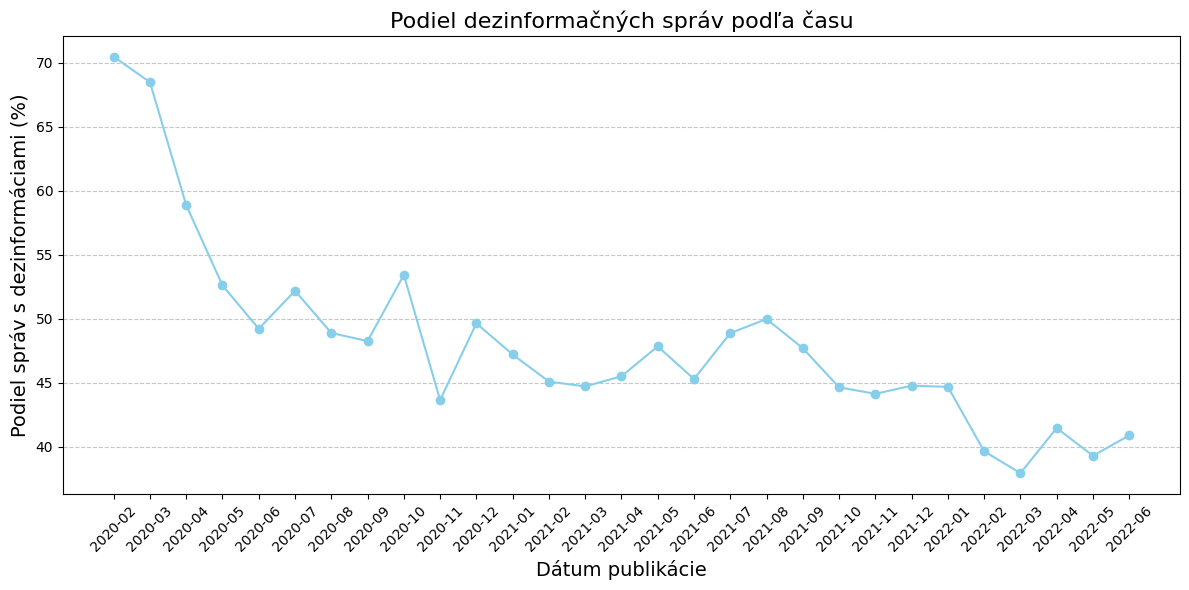

In [22]:
#Zoskupenie podľa month_year a počítanie počtu všetkých a falošných postov
grouped = df_pred.groupby('month_year').agg(
    total_posts=('prediction', 'count'),
    fake_posts=('prediction', lambda x: (x == 'fake').sum())
).reset_index()

#Výpočet percenta falošných postov za každé obdobie
grouped['fake_percentage'] = (grouped['fake_posts'] / grouped['total_posts']) * 100

#Vizualizacia
plt.figure(figsize=(12, 6))
plt.plot(grouped['month_year'], grouped['fake_percentage'], marker='o', color='skyblue', linestyle='-')

plt.title('Podiel dezinformačných správ podľa času', fontsize=16)
plt.xlabel('Dátum publikácie', fontsize=14)
plt.ylabel('Podiel správ s dezinformáciami (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()